# Computation of the kernel models with an HPL trace

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

In [2]:
archive_name = '../../exp_output/kernel_calibration/grenoble_2019-01-28_1843947.zip'
experiments = read_csv(archive_name, 'exp.csv')
sizes = list(experiments.matrix_size)
print(sizes)
experiments

[400000, 20000, 100000, 10000, 50000, 200000]


,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,400000,128,16,32,1,2,2,1,0,8,32,1
1,20000,128,16,32,1,2,2,1,0,8,32,1
2,100000,128,16,32,1,2,2,1,0,8,32,1
3,10000,128,16,32,1,2,2,1,0,8,32,1
4,50000,128,16,32,1,2,2,1,0,8,32,1
5,200000,128,16,32,1,2,2,1,0,8,32,1


In [3]:
import sys

def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace['kind'] = 'BLAS'
    blas_trace['function'] = blas_trace['function'].str.strip()
    df = blas_trace
    df['rank+1'] = df['rank'] + 1
    df['exp_id'] = exp_id
    return df

traces = []
trace_reality = None
nbrow_limit = 2000000
for i, size in enumerate(sizes):
    print('Exp %d (matrix_size=%d)' % (i, size))
    tmp_trace = read_archive(archive_name, i)
    tmp_trace['matrix_size'] = size
    if len(tmp_trace) > nbrow_limit:
        sys.stderr.write('WARNING: dataframe for exp %d (matrix_size=%d) has %d rows, keeping %d' % (i, size, len(tmp_trace), nbrow_limit))
    tmp_trace = tmp_trace.head(n=nbrow_limit)
    if trace_reality is not None:
        trace_reality = pandas.concat([trace_reality, tmp_trace])
    else:
        trace_reality = tmp_trace

trace_reality.head()

Exp 0 (matrix_size=400000)
Exp 1 (matrix_size=20000)


Exp 2 (matrix_size=100000)
Exp 3 (matrix_size=10000)


Exp 4 (matrix_size=50000)


Exp 5 (matrix_size=200000)


,file,line,function,rank,timestamp,duration,m,n,k,start,end,kind,rank+1,exp_id,matrix_size
0,../HPL_dlocmax.c,125,idamax,0,7.113828,0.000033,25088,NaN,NaN,7.113828,7.113861,BLAS,1,0,400000
1,../HPL_pdmxswp.c,165,dcopy,0,7.113882,0.000007,128,NaN,NaN,7.113882,7.113889,BLAS,1,0,400000
2,../HPL_pdmxswp.c,167,dcopy,0,7.113891,0.000001,128,NaN,NaN,7.113891,7.113892,BLAS,1,0,400000
3,../HPL_pdpancrT.c,214,dscal,0,7.982221,0.000015,25087,NaN,NaN,7.982221,7.982236,BLAS,1,0,400000
4,../HPL_pdpancrT.c,234,dgemv,0,7.982238,0.000140,25087,1.0,NaN,7.982238,7.982378,BLAS,1,0,400000


In [4]:
trace_reality.head()

,file,line,function,rank,timestamp,duration,m,n,k,start,end,kind,rank+1,exp_id,matrix_size
0,../HPL_dlocmax.c,125,idamax,0,7.113828,0.000033,25088,NaN,NaN,7.113828,7.113861,BLAS,1,0,400000
1,../HPL_pdmxswp.c,165,dcopy,0,7.113882,0.000007,128,NaN,NaN,7.113882,7.113889,BLAS,1,0,400000
2,../HPL_pdmxswp.c,167,dcopy,0,7.113891,0.000001,128,NaN,NaN,7.113891,7.113892,BLAS,1,0,400000
3,../HPL_pdpancrT.c,214,dscal,0,7.982221,0.000015,25087,NaN,NaN,7.982221,7.982236,BLAS,1,0,400000
4,../HPL_pdpancrT.c,234,dgemv,0,7.982238,0.000140,25087,1.0,NaN,7.982238,7.982378,BLAS,1,0,400000


In [5]:
for exp in sorted(trace_reality['exp_id'].unique()):
    tmp = trace_reality[trace_reality['exp_id'] == exp]
    print('exp %d: %.2f → %.2f' % (exp, tmp['start'].min(), tmp['end'].max()))

exp 0: 7.11 → 36.50
exp 1: 0.04 → 0.20
exp 2: 0.45 → 2.44
exp 3: 0.01 → 0.11
exp 4: 0.12 → 0.71
exp 5: 1.77 → 9.13


## Counting the number of events

In [6]:
trace_reality.groupby(['function', 'matrix_size'])[['duration']].agg(['count', 'sum'])

duration            
                             count         sum
function      matrix_size                     
HPL_dlacpy    10000              9    0.002102
              20000             15    0.007631
              50000             61    0.077430
              100000            96    0.226027
              200000            96    0.476467
              400000            96    1.422491
HPL_dlaswp01T 10000             47    0.008598
              20000             71    0.029623
              50000             95    0.101222
              100000           165    0.396192
              200000           165    0.918403
              400000           165    2.269168
HPL_dlaswp02N 10000            183    0.005233
              20000            383    0.026779
              50000           1537    0.268651
              100000          2475    0.953435
              200000          2475    2.452808
              400000          2475    6.990629
HPL_dlaswp03T 10000            488    0.014083
              20000            933    0.067807
              50000           1917    0.479839
              100000          2475    1.160163
              200000          2475    2.540578
              400000          2475    4.971160
HPL_dlaswp04T 10000            183    0.008713
              20000            383    0.062243
              50000           1537    0.834286
              100000          2475    3.015938
              200000          2475    6.317445
              400000          2475   12.893202
...                            ...         ...
dgemv         10000            796    0.010227
              20000           1807    0.107677
              50000          11492    2.569249
              100000         30912   16.557269
              200000         55904   66.102390
              400000        105888  264.024505
dscal         10000           1152    0.000372
              20000           1920    0.001101
              50000           7808    0.009428
              100000         12288    0.028720
              200000         12288    0.057962
              400000         12288    0.117130
dtrsm         10000         995652    0.124144
              20000         992263    0.380584
              50000         967212    2.944897
              100000         59184    8.158505
              200000         39815   15.588274
              400000         34335   28.881442
dtrsv         10000              8    0.000167
              20000             30    0.000601
              50000            245    0.004740
              100000           782    0.015914
              200000          1563    0.037165
              400000          3125    0.081702
idamax        10000           1166    0.000662
              20000           1945    0.001749
              50000           7890    0.014458
              100000         12401    0.046365
              200000         12401    0.092468
              400000         12401    0.188972

[84 rows x 2 columns]

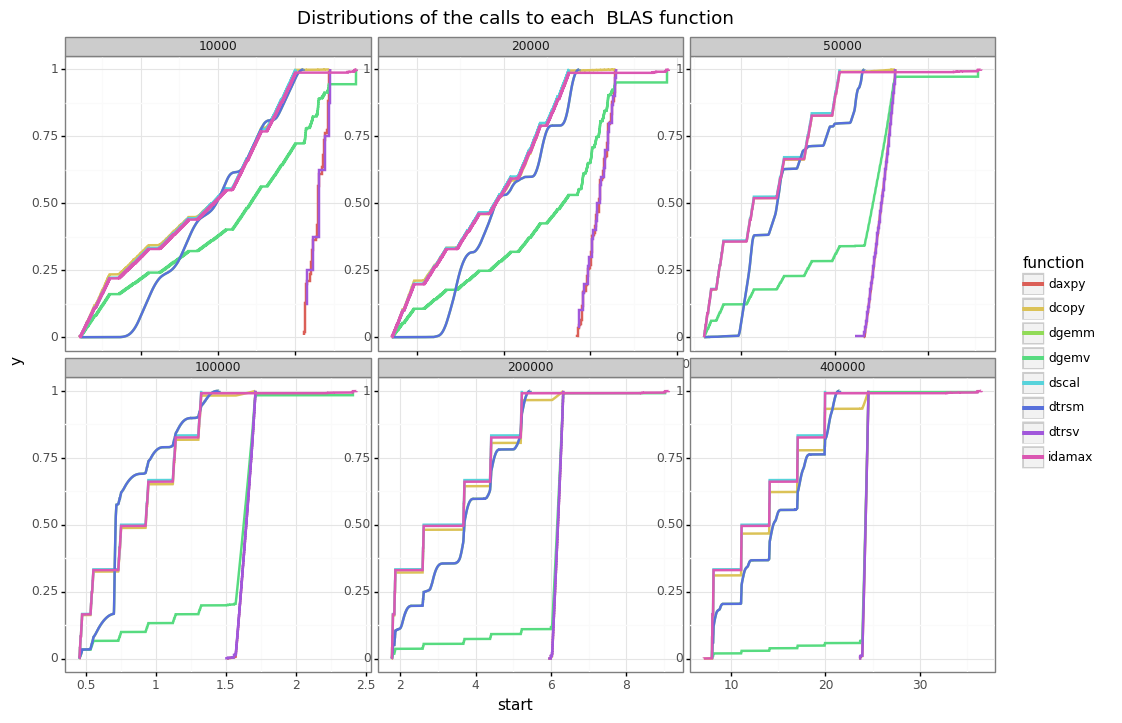

<ggplot: (8734770974696)>

In [7]:
plot = ggplot(trace_reality[(trace_reality['kind'] == 'BLAS') & (~trace_reality.function.str.startswith('HPL_'))], aes('start', group='function', color='function'))
plot + stat_ecdf(size=1) + ggtitle('Distributions of the calls to each  BLAS function') + theme_bw() + facet_wrap('matrix_size', scales='free')

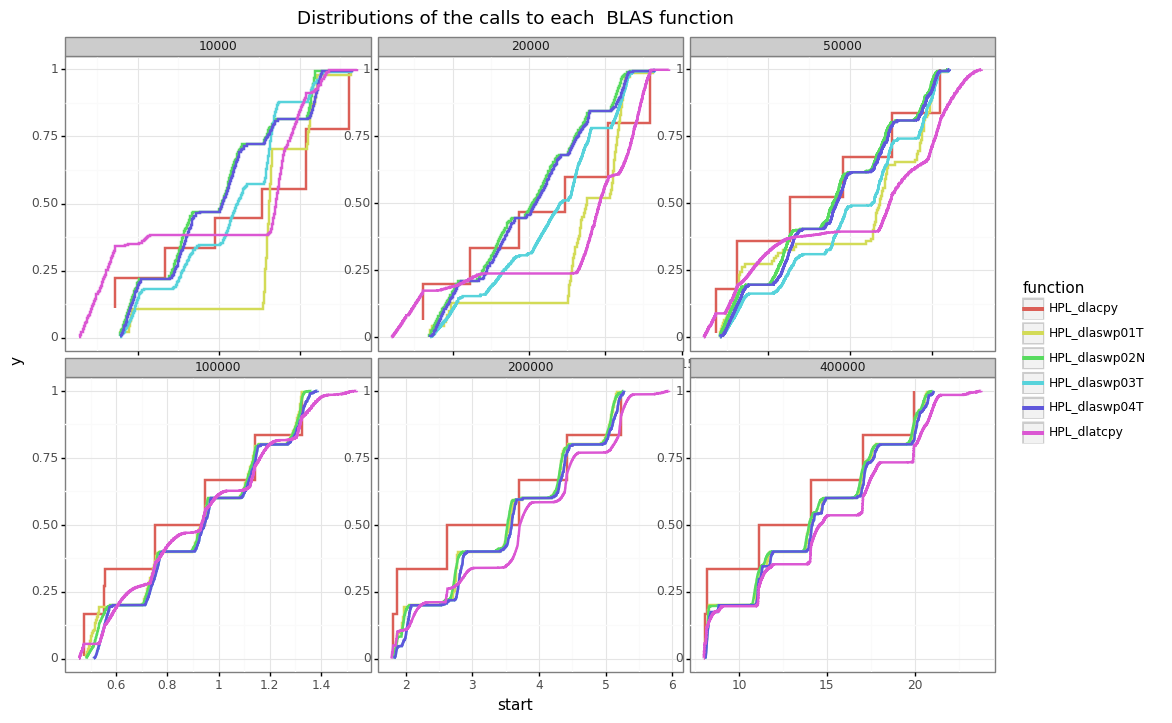

<ggplot: (8734761229439)>

In [8]:
plot = ggplot(trace_reality[(trace_reality['kind'] == 'BLAS') & (trace_reality.function.str.startswith('HPL_'))], aes('start', group='function', color='function'))
plot + stat_ecdf(size=1) + ggtitle('Distributions of the calls to each  BLAS function') + theme_bw() + facet_wrap('matrix_size', scales='free')

## Plotting the durations

In [9]:
blas = trace_reality[trace_reality['kind'] == 'BLAS'].copy().reset_index()
blas['size_product'] = -1
blas.loc[blas.function == 'dgemm', 'size_product'] = blas.m * blas.n * blas.k
blas.loc[blas.function == 'dtrsm', 'size_product'] = blas.m * blas.n**2
blas.loc[blas.function == 'dtrsv', 'size_product'] = blas.m**2
for func in ['dgemv']:
    blas.loc[blas.function == func, 'size_product'] = blas.m * blas.n
for func in ['daxpy', 'dcopy', 'dscal', 'idamax']:
    blas.loc[blas.function == func, 'size_product'] = blas.m

blas.loc[blas.function.str.startswith('HPL_'), 'size_product'] = blas.m * blas.n
for func in ['HPL_dlaswp04N', 'HPL_dlaswp04T']:
    blas.loc[blas.function == func, 'size_product'] = blas.n * blas.k

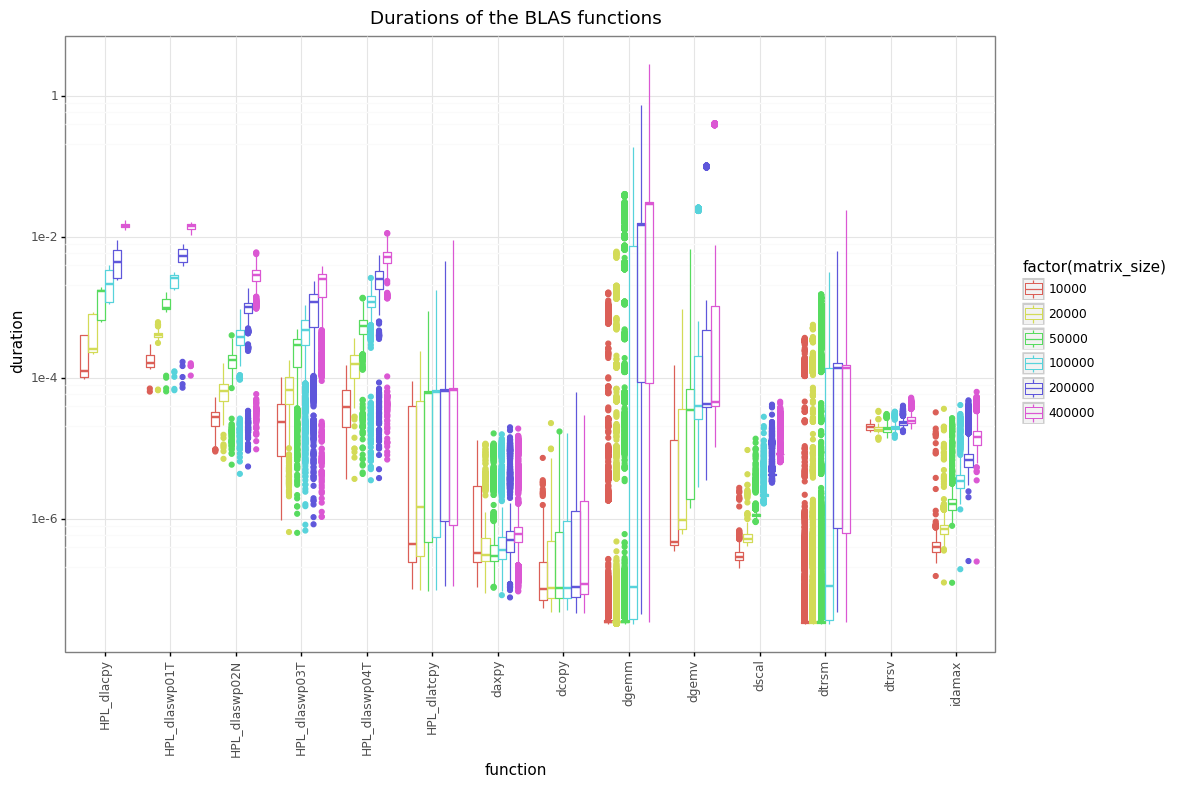

<ggplot: (-9223363301960167445)>

In [10]:
plot = ggplot(blas, aes(x='function', y='duration', color='factor(matrix_size)')) + scale_y_log10()
plot = plot + theme_bw() + ggtitle('Durations of the BLAS functions') + geom_boxplot(alpha=0)
plot + theme(axis_text_x=element_text(rotation=90))

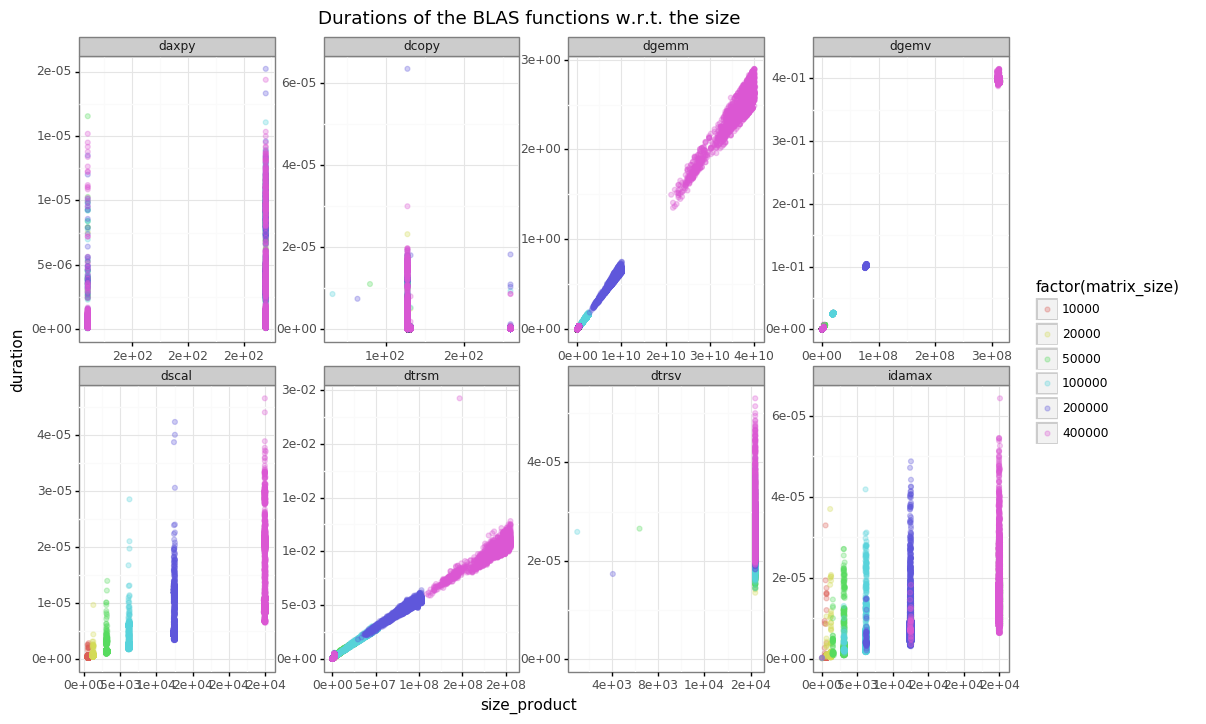

<ggplot: (8734770975247)>

In [11]:
def plot_size(df):
    my_label = lambda l: ['%.0e' % x for x in l]
    plot = ggplot(df, aes(x='size_product', y='duration', color='factor(matrix_size)')) + geom_point(alpha=0.3)
    plot = plot + facet_wrap('function', scales='free', nrow=2) + theme_bw() + ggtitle('Durations of the BLAS functions w.r.t. the size')
    plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25}) + expand_limits(y=0) # the subplots_adjust is to fix a display bug...
    return plot + scale_y_continuous(labels=my_label) + scale_x_continuous(labels=my_label)

plot_size(blas[~blas.function.str.startswith('HPL_')])

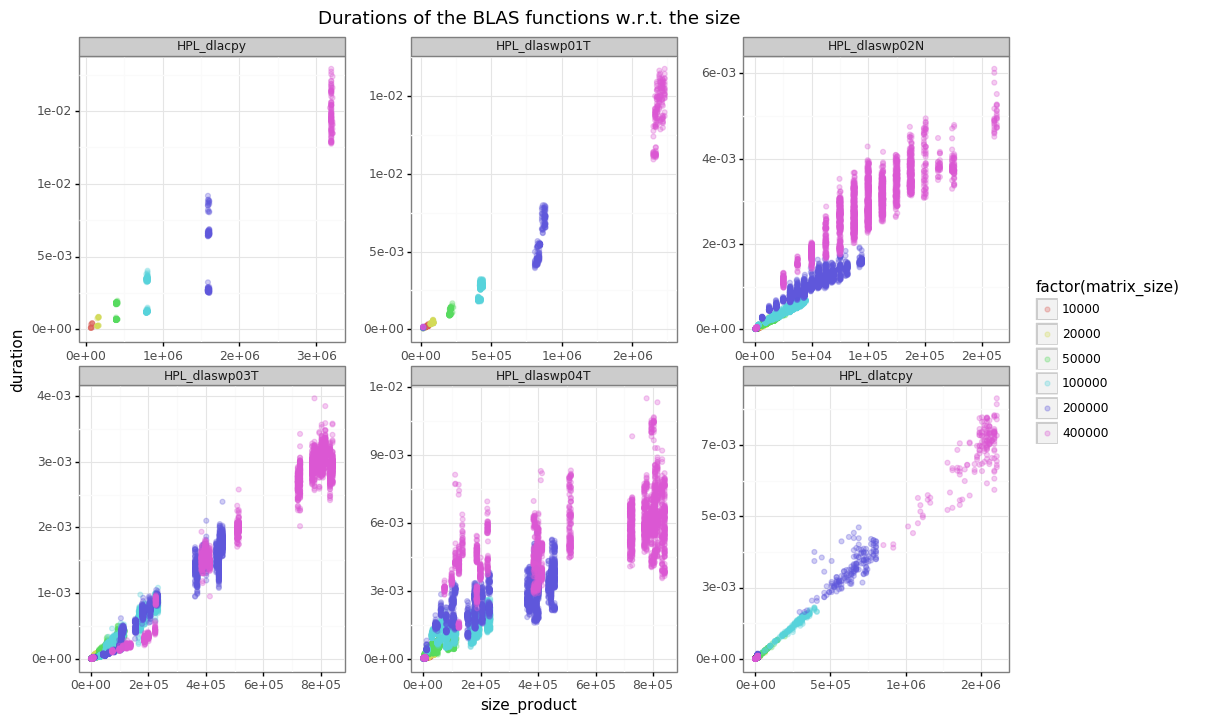

<ggplot: (-9223363302057843333)>

In [12]:
plot_size(blas[blas.function.str.startswith('HPL_')])

## Computing the coefficients

In [13]:
blas = blas[blas.size_product > 0].copy()
blas['ratio'] = blas['duration'] / blas['size_product']

def plot_hist(df, x):
    plot = ggplot(df, aes(x=x)) + geom_histogram(bins=30)
    plot = plot + facet_wrap('function', scales='free', nrow=2) + theme_bw() + ggtitle('Distribution of the %s' % x)
    plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25})  # the subplots_adjust is to fix a display bug...
    return plot

In [14]:
blas['large_size'] = False
for func in blas.function.unique():
    max_size = blas[blas['function'] == func]['size_product'].max()
    blas.loc[(blas['function'] == func) & (blas['size_product'] > max_size/3), 'large_size'] = True

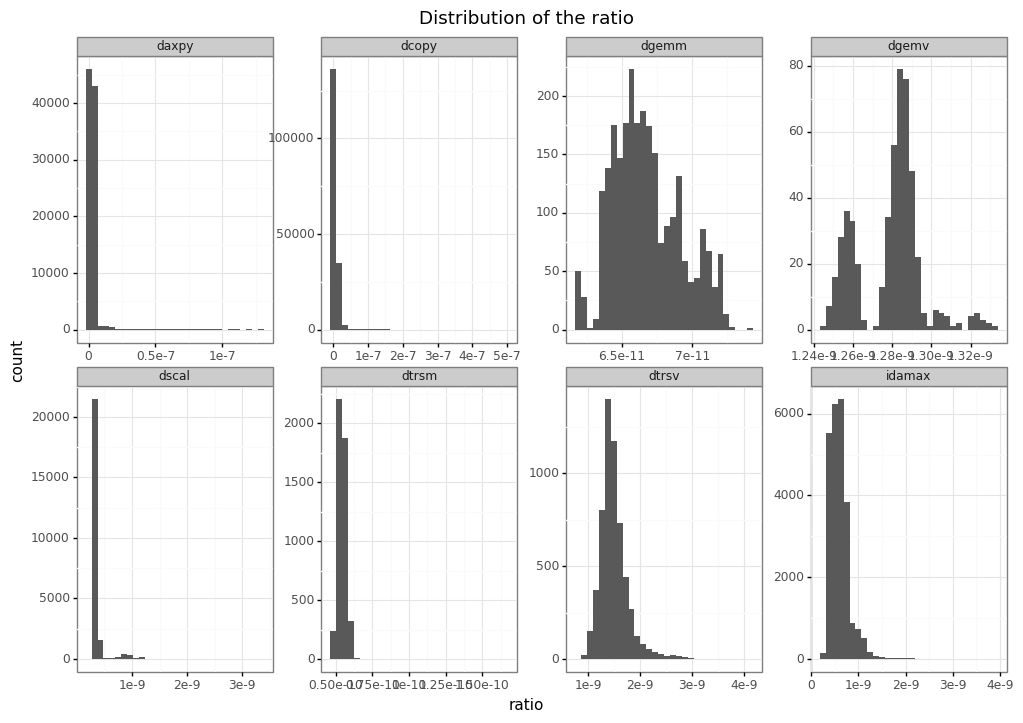

<ggplot: (8734689524116)>

In [15]:
plot_hist(blas[(~blas.function.str.startswith('HPL_')) & (blas.large_size)], x='ratio')

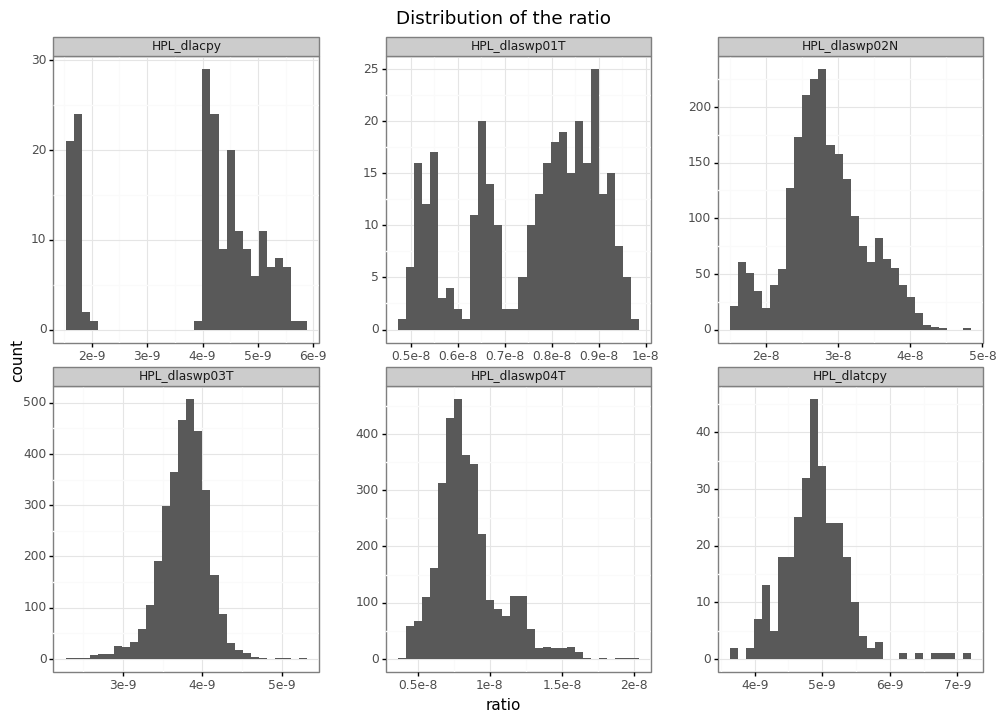

<ggplot: (8734804093227)>

In [16]:
plot_hist(blas[(blas.function.str.startswith('HPL_')) & (blas.large_size)], x='ratio')

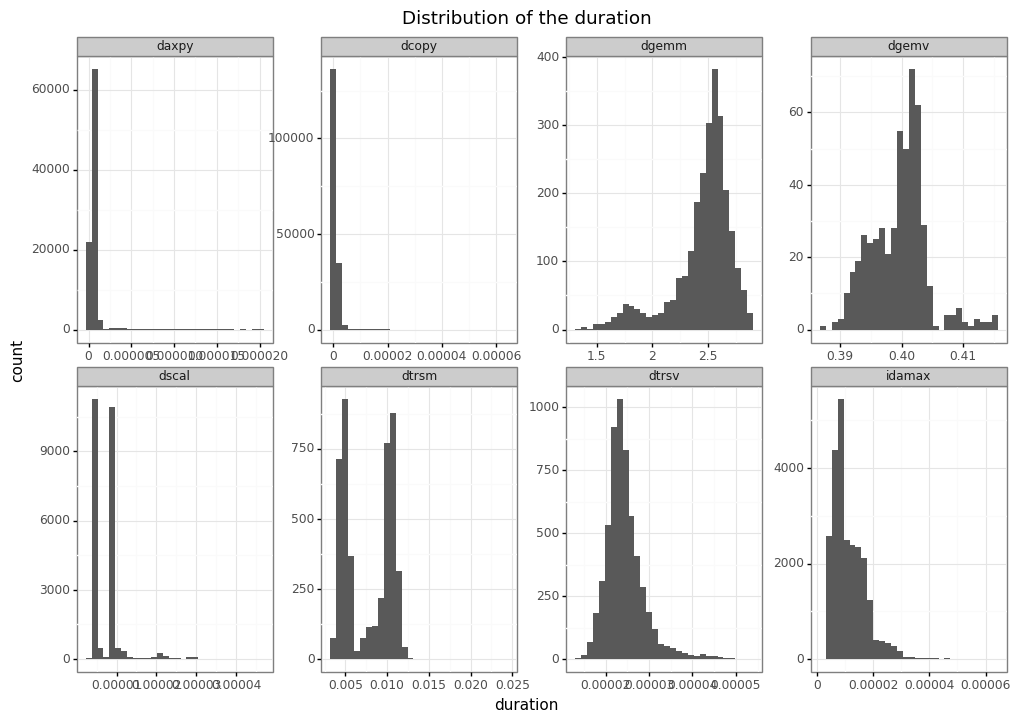

<ggplot: (-9223363302051354529)>

In [17]:
plot_hist(blas[(~blas.function.str.startswith('HPL_')) & (blas.large_size)], x='duration')

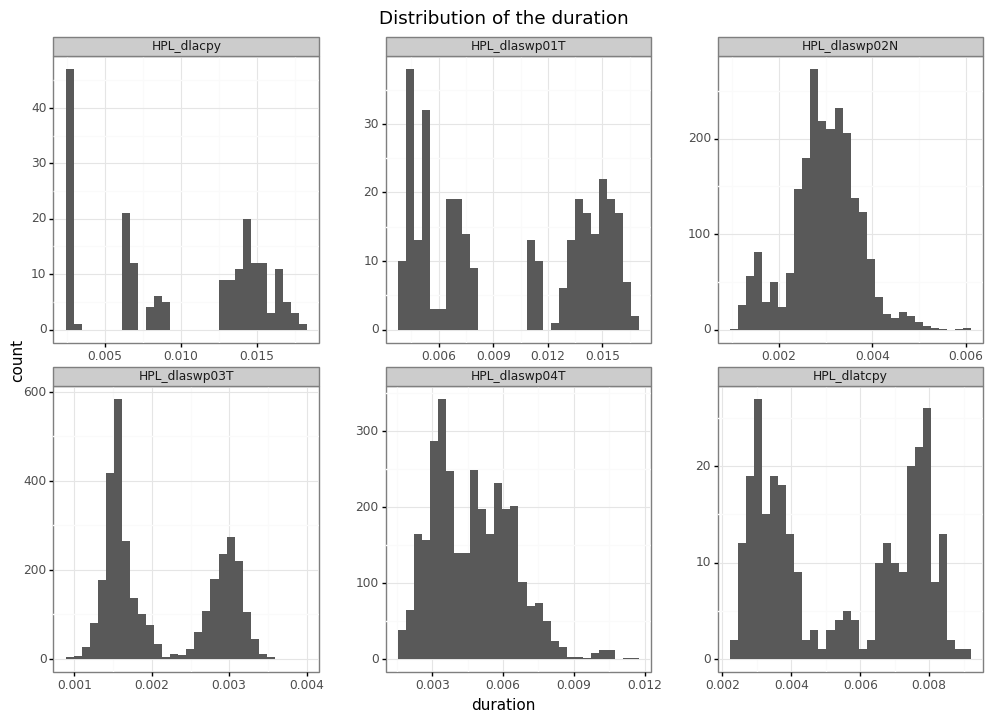

<ggplot: (8734803503196)>

In [18]:
plot_hist(blas[(blas.function.str.startswith('HPL_')) & (blas.large_size)], x='duration')

In [19]:
coefficients = blas[blas.large_size].groupby('function')[['ratio', 'duration']].agg(['mean', 'std']).reset_index()

In [20]:
coefficients

function         ratio                    duration              
                           mean           std          mean           std
0      HPL_dlacpy  3.871806e-09  1.328595e-09  9.890408e-03  5.295471e-03
1   HPL_dlaswp01T  7.547639e-09  1.371708e-09  9.957072e-03  4.450018e-03
2   HPL_dlaswp02N  2.822241e-08  5.497050e-09  2.976250e-03  7.339725e-04
3   HPL_dlaswp03T  3.775240e-09  2.968320e-10  2.126850e-03  7.088566e-04
4   HPL_dlaswp04T  8.498957e-09  2.218070e-09  4.704189e-03  1.680727e-03
5     HPL_dlatcpy  4.893900e-09  4.691039e-10  5.446391e-03  2.120121e-03
6           daxpy  2.758333e-09  4.009468e-09  6.680085e-07  9.265829e-07
7           dcopy  4.539540e-09  8.301535e-09  5.909855e-07  1.059787e-06
8           dgemm  6.674693e-11  2.429562e-12  2.454527e+00  2.675189e-01
9           dgemv  1.278804e-09  1.645759e-11  3.996129e-01  4.524796e-03
10          dscal  3.798686e-10  1.490121e-10  7.124494e-06  3.853608e-06
11          dtrsm  5.445540e-11  3.093410e-12  7.716231e-03  2.767563e-03
12          dtrsv  1.488873e-09  2.739752e-10  2.438651e-05  4.452153e-06
13         idamax  6.052262e-10  2.380847e-10  1.136407e-05  5.932021e-06

In [21]:
import numpy
blas['coefficient'] = -1
for func in coefficients.function.unique():
    size = len(blas[blas.function == func])
    func_row = coefficients[coefficients.function == func]
    mean_ratio = list(func_row['ratio']['mean'])[0]
    std_ratio = list(func_row['ratio']['std'])[0]
    mean_duration = list(func_row['duration']['mean'])[0]
    std_duration = list(func_row['duration']['std'])[0]
    blas.loc[blas.function == func, 'exp_ratio'] = numpy.random.normal(loc=mean_ratio, scale=std_ratio, size=size)
    blas.loc[blas.function == func, 'exp_duration'] = numpy.random.normal(loc=mean_duration, scale=std_duration, size=size)

In [22]:
linear_functions = {'dgemm', 'dgemv', 'dtrsm', 'HPL_dlaswp02N', 'HPL_dlaswp03T', 'HPL_dlatcpy'}  # what we used to consider as "linear"
linear_functions = {'dgemm', 'dgemv', 'dscal', 'dtrsm', 'idamax', 'HPL_dlacpy', 'HPL_dlaswp01T', 'HPL_dlaswp02N', 'HPL_dlaswp03T', 'HPL_dlaswp04T', 'HPL_dlatcpy'}
blas['estimation'] = -1

for func in set(blas.function.unique()) & linear_functions:
    tmp = blas[blas.function == func]
    blas.loc[blas.function == func, 'estimation'] = tmp['size_product'] * tmp['exp_ratio']

for func in set(blas.function.unique()) - linear_functions:
    tmp = blas[blas.function == func]
    blas.loc[blas.function == func, 'estimation'] = tmp['exp_duration']

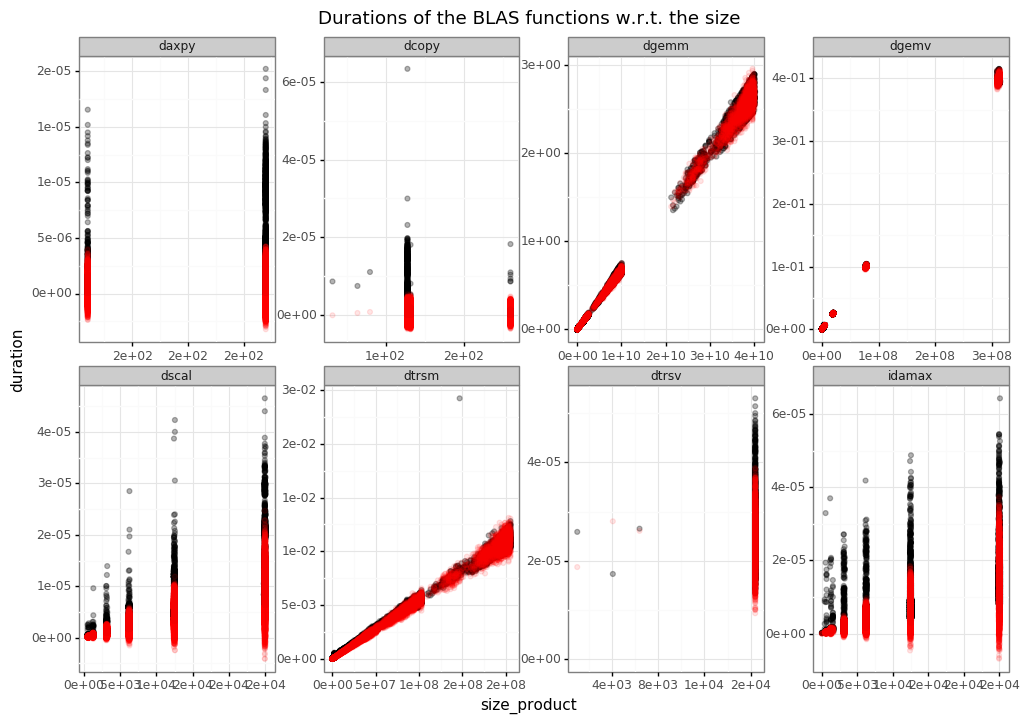

<ggplot: (8734804430975)>

In [23]:
my_label = lambda l: ['%.0e' % x for x in l]
plot = ggplot(blas[~blas.function.str.startswith('HPL_')], aes(x='size_product', y='duration')) + geom_point(alpha=0.3)
plot = plot + geom_point(aes(x='size_product', y='estimation'), color='red', alpha=0.1)
plot = plot + facet_wrap('function', scales='free', nrow=2) + theme_bw() + ggtitle('Durations of the BLAS functions w.r.t. the size')
plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25})  # the subplots_adjust is to fix a display bug...
plot = plot + scale_y_continuous(labels=my_label) + scale_x_continuous(labels=my_label) + expand_limits(y=0)
plot

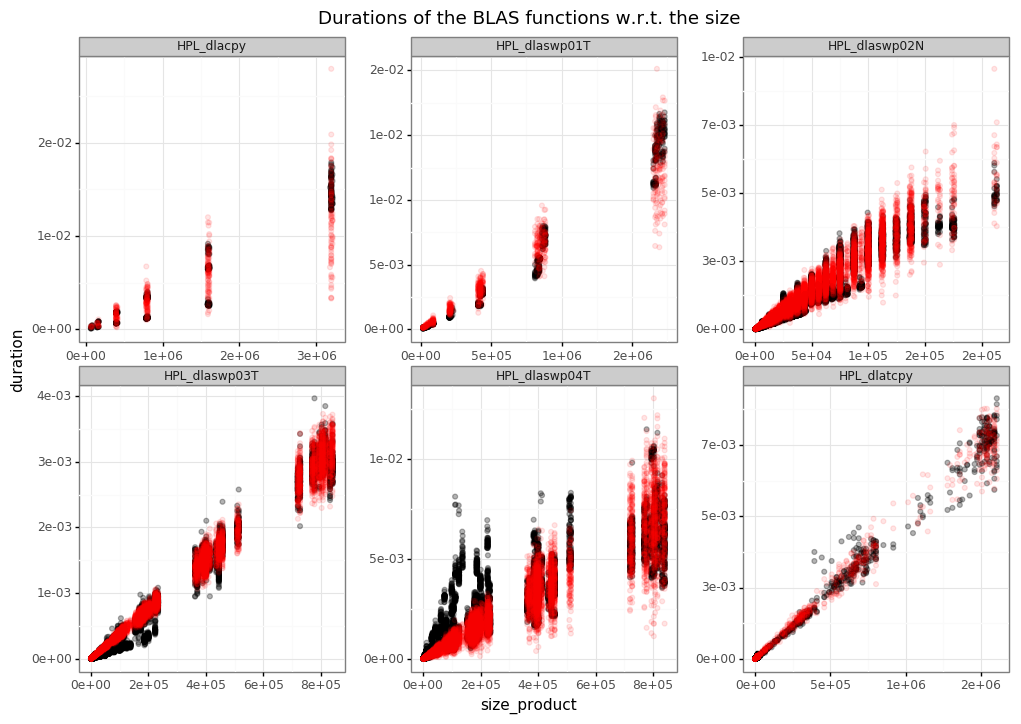

<ggplot: (8734803124232)>

In [24]:
plot = ggplot(blas[blas.function.str.startswith('HPL_')], aes(x='size_product', y='duration')) + geom_point(alpha=0.3)
plot = plot + geom_point(aes(x='size_product', y='estimation'), color='red', alpha=0.1)
plot = plot + facet_wrap('function', scales='free', nrow=2) + theme_bw() + ggtitle('Durations of the BLAS functions w.r.t. the size')
plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25})  # the subplots_adjust is to fix a display bug...
plot = plot + scale_y_continuous(labels=my_label) + scale_x_continuous(labels=my_label) + expand_limits(y=0)
plot

In [25]:
blas.groupby('function')[['duration', 'estimation']].agg(['sum', 'min', 'max'])

duration                           estimation                \
                       sum           min       max          sum           min   
function                                                                        
HPL_dlacpy        2.212149  9.920700e-05  0.017902     2.128939  1.938396e-04   
HPL_dlaswp01T     3.723205  6.479900e-05  0.016756     3.747254  1.074445e-04   
HPL_dlaswp02N    10.697536  4.416000e-06  0.006108    12.480050  2.902180e-06   
HPL_dlaswp03T     9.233629  6.430000e-07  0.003965     9.568617  9.498536e-07   
HPL_dlaswp04T    23.131828  3.582000e-06  0.011485    20.941920  2.427624e-06   
HPL_dlatcpy       2.235924  9.500000e-08  0.009135     2.308007  1.606167e-08   
daxpy             0.061079  7.800000e-08  0.000020     0.061217 -3.215876e-06   
dcopy             0.103145  4.700000e-08  0.000063     0.103132 -3.756915e-06   
dgemm          9141.151675  1.847000e-06  2.897208  9022.970521  1.258390e-07   
dgemv           349.371316  3.540000e-07  0.415311   406.260672  6.355784e-07   
dscal             0.214713  2.070000e-07  0.000047     0.213881 -4.106295e-06   
dtrsm            55.970438  1.950000e-07  0.024241    52.368600  3.446027e-10   
dtrsv             0.140290  1.344600e-05  0.000053     0.139986  9.273749e-06   
idamax            0.344674  1.260000e-07  0.000064     0.344409 -6.889082e-06   

                         
                    max  
function                 
HPL_dlacpy     0.027943  
HPL_dlaswp01T  0.020126  
HPL_dlaswp02N  0.009568  
HPL_dlaswp03T  0.003727  
HPL_dlaswp04T  0.013034  
HPL_dlatcpy    0.008768  
daxpy          0.000004  
dcopy          0.000005  
dgemm          2.955724  
dgemv          0.413973  
dscal          0.000025  
dtrsm          0.013117  
dtrsv          0.000039  
idamax         0.000037